In [ ]:
# Split features into types and create target feature df
# def split_features(df):
#     print('{} features to be split'.format(df.shape[1]))
#     categorical_features = df.columns[df.dtypes == 'object'].tolist()
#     numeric_features_float = df.select_dtypes(include=['float']).columns.tolist()
#     numeric_features_integer = df.select_dtypes(include=['integer']).columns.tolist()
#     print('\nCategorical:\n', len(categorical_features), categorical_features)
#     print('\nFloat:\n',len(numeric_features_float), numeric_features_float)
#     print('\nInteger:\n',len(numeric_features_integer), numeric_features_integer)
#     print('\n')
#     print('{} + {} + {} = {} features have been split'.
#           format(len(categorical_features), len(numeric_features_float), len(numeric_features_integer),
#                  len(categorical_features) + len(numeric_features_float) + len(numeric_features_integer)))
    
#     return categorical_features, numeric_features_float, numeric_features_integer

# categorical_features, numeric_features_float, numeric_features_integer = split_features(df_train)

# **Acknowledgements**
To the following whose kernels I used extensively for this kernel:
* Manav Sehgal - "Titanic Data Science Solutions" - https://www.kaggle.com/startupsci/titanic-data-science-solutions/notebook
* Pedro Marcelino - "Comprehensive data exploration with Python" - https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
* Serigne - "Stacked Regressions to predict House Prices" - https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
    
I highly recommend exploring these kernels to get a more indepth understanding of their respective approaches and also useful links.

# Me

I'm new to data science and this is my second challenge and Notebook.  So please excuse inefficient code as I learn:
* MathPlotLib abd Seaborn - I've spent ages learning about these libraries as I developed this Notebook
* Stats (e.g. testign assumptions) - learnt a lot about that developing this too - thanks to Pedro (see acknowledgements)
* Python


# **Workflow Stages**
***

**1. Question or problem definition**

    This competition challenges you to predict the final price of each home.
    
    
**2. Acquire training and testing data**

    Provided - 81 variables - including the Id and predictor variable SalesPrice


**3. Data Analysis**

    3.1. Analyse by describing the data
   
        * Explore features (meta data)
        * Initial examination of the variables, segments, types and meaning

    3.2. Explore the target feature - SalePrice
   
        3.2.1. Univariate study - Focus on the target feature and try to know a little bit more about it.
    
        3.2.2. Bivariate study - Try to understand how the target feature relates to other features
       
            * Examine numerical features
            * Examine categorical features

        3.2.3. Multivariate study
   
           We'll use heatmaps and correlations to examine the interlationships between all the features
           
**4. Data Processing**

    4.3. Analysing and Deleting Outliers

**4. Feature Engineering - prepare and cleanse the before modelling**
    
    4.1. Drop features with large numbers of null values
    4.2. Drop features due to overlapping feature meaning
    4.3. Create / derive new features from existing
    
    4.4. Impute missing values by considering each feature one by one
    4.5. Transforming numerical features which are actually categorical
    4.6. Label encoding - some features may contain some information in their ordering set
    4.7. Log transformation of skewed values (consider / compare Box-Cox and Arcsine transformations)
    4.8. Get dummy features for categoprical features
    
**5. Model, predict and solve the problem**

    5.1. Choose base models
    5.2. Cross validate the models
    5.3. Stack/Ensemble the models

**6. Visualize, report, and present the problem solving steps and final solution.**


**7. Supply or submit the results**

In [33]:
# Data analysis and wranging
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import sys
import os
from decimal import *
import warnings

# Set ipython's max row, max columns and display width display settings
pd.set_option('display.max_row', 1000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 400)
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline

# machine learning
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
# Feature selection
from sklearn.feature_selection import RFE

# Create the function to enable us to stop deprecated function warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)
    
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

def feature_null_analysis(df_desc, df, drop_theshold): 
    # Create lists of information we want to see
    feat_names = list(df)
    feat_dtype = list(df.dtypes)
    feat_default = ['Mode: ' + df[feat].mode()[0] if df[feat].dtype == 'object' else 'Median: ' + str(df[feat].median()) for feat in list(df)]
    feat_default_perc = x = ['%/total: ' + str(round(((df_train[feat].value_counts().iloc[0] / df_train.shape[0]) * 100),2))
                             if df_train[feat].dtype == 'object' else '' for feat in list(df_train)]
    feat_nulls = df.isnull().sum()
    feat_nullperc = df.isnull().mean() * 100
    feat_dropind = ['Y' if val >= drop_theshold else 'N' for val in feat_nullperc]
    
    # Combine the info into one soreted list
    feat_analysis_all = sorted(list(zip(feat_names,feat_dtype,feat_default,feat_default_perc,feat_nulls,feat_nullperc, feat_dropind))
                               ,key=lambda x: x[4], reverse=True)
    feat_analysis_nulls = [feat for feat in feat_analysis_all if feat[5] > 0]  # features with nulls
    feat_droplist = [feat[0] for feat in feat_analysis_all if feat[5] >= 15]  # features recommended to drop
    
    # Pass back the list of features recommended to drop to make it easier to drop them
    return feat_analysis_nulls, feat_droplist

def print_feature_null_analysis(df_desc, feat_analysis):
    # print the analysis
    print('\n{: >{width}}'.format(df_desc, width=2 * PRINT_WIDTH))
    print('{: >{width}}'.format('+++++++++', width=2 * PRINT_WIDTH))
    print('{: <{width}}{: <{width}}{: <{width}}{: <{width}}{: <{width}}{: <{width}}{: <{width}}'.
          format('Feature','DType','Mode/Median','Perc. Rows = Mode','No. Nulls','Perc. Nulls','Drop? (Y/N)', width=PRINT_WIDTH))
    print('{: <{width}}{: <{width}}{: <{width}}{: <{width}}{: <{width}}{: <{width}}{: <{width}}'.
          format('=======','=====','===========','=================','=========','===========','=====', width=PRINT_WIDTH))
    
    for feat in feat_analysis:
        print('{: <{width}}{: <{width}}{: <{width}}{: <{width}}{: <{width}}{: <{width}.2F}{: <{width}}'.
              format(feat[0],str(feat[1]),feat[2],feat[3],feat[4],feat[5],feat[6], width=PRINT_WIDTH))

def drop_features(df_desc, df, feats_to_drop):
    print('\nBefore shape for {}: {}'.format(df_desc, df.shape))
    df.drop(feats_to_drop, axis=1, inplace=True)
    print('\nAfter shape for {}: {}'.format(df_desc, df.shape))
    feat_analysis_nulls, feat_droplist = feature_null_analysis(df_desc, df, NULL_PERC_DROP_PERC)  # As we've dropped one or more features we need to recreate the analysis
    return feat_analysis_nulls, FEATURES_DROPPED + feats_to_drop

# def drop_target_feature(df):
#     target_feature_data = df[TARGET_FEATURE]
#     df.drop(TARGET_FEATURE, axis=1, inplace=True)
#     return target_feature_data

FEATURES_DROPPED = [] # Track the features we drop to make sure we don'y lose any as we wrangle ;-)
NULL_PERC_DROP_PERC = 15  # Set the threshold percentage of nulls in a column - will determine if it's recommended to drop
PRINT_WIDTH = 20  # Print parameter
TARGET_FEATURE = ['SalePrice']
ID_FEATURE = ['Id']

# 1. Question or problem definition

This competition challenges you to predict the final price of each home.

# 2. Acquire training and test data

In [7]:
# Check files in input directory - Windows
input_dir = 'C:/Users/770000411/OneDrive - Genpact/02 - Personal/Jupyter Projects/Predict House Prices'
l = list(os.listdir(input_dir))
for f in l:
    print(f)
    
# Check files in input directory - Unix
# from subprocess import check_output
# print(check_output(["ls", 'C:/Users/770000411/OneDrive - Genpact/02 - Personal/Jupyter Projects/Predict House Prices']).decode("utf8")) #check the files available in the directory

.git
.gitattributes
.gitignore
.ipynb_checkpoints
Ames, Iowa - House Price Prediction (ref-Copy1. Kaggle Challenge).ipynb
Ames, Iowa - House Price Prediction (ref. Kaggle Challenge).ipynb
Backup
data_description.txt
Feature Analysis.xlsx
Features Analysis.docx
submission - Decision Tree.csv
submission - Random Forests.csv
submission.csv
test.csv
train.csv


In [9]:
# Import Train and Test data
df_train = pd.read_csv('C:/Users/770000411/OneDrive - Genpact/02 - Personal/Jupyter Projects/Predict House Prices/train.csv')
df_test = pd.read_csv('C:/Users/770000411/OneDrive - Genpact/02 - Personal/Jupyter Projects/Predict House Prices/test.csv')

df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [10]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,CBlock,TA,TA,No,Rec,468.000,LwQ,144.000,270.000,882.000,GasA,TA,Y,SBrkr,896,0,0,896,0.000,0.000,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.000,Unf,1.000,730.000,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.000,TA,TA,CBlock,TA,TA,No,ALQ,923.000,Unf,0.000,406.000,1329.000,GasA,TA,Y,SBrkr,1329,0,0,1329,0.000,0.000,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.000,Unf,1.000,312.000,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,PConc,Gd,TA,No,GLQ,791.000,Unf,0.000,137.000,928.000,GasA,Gd,Y,SBrkr,928,701,0,1629,0.000,0.000,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.000,Fin,2.000,482.000,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.000,TA,TA,PConc,TA,TA,No,GLQ,602.000,Unf,0.000,324.000,926.000,GasA,Ex,Y,SBrkr,926,678,0,1604,0.000,0.000,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.000,Fin,2.000,470.000,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.000,Gd,TA,PConc,Gd,TA,No,ALQ,263.000,Unf,0.000,1017.000,1280.000,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.000,0.000,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.000,RFn,2.000,506.000,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [11]:
# Save then drop the Id column from Train and Test - not needed for modelling/prediction

# Save Id
train_id = df_train['Id']
test_id = df_train['Id']

# Print shapes before drop
print('\nBefore shape for {}: {}'.format('df_train', df_train.shape))
print('\nBefore shape for {}: {}'.format('df_test', df_test.shape))

# Drop Id
df_train.drop('Id', axis=1, inplace=True)
df_test.drop('Id', axis=1, inplace=True)

# Print shapes after drop
print('\nAfter shape for {}: {}'.format('df_train', df_train.shape))
print('\nAfter shape for {}: {}'.format('df_test', df_test.shape))


Before shape for df_train: (1460, 81)

Before shape for df_test: (1459, 80)

After shape for df_train: (1460, 80)

After shape for df_test: (1459, 79)


## 2.1 Split features into types to enable analysis

## Identify features with excessive null values

The process of dealing with nulls is heavily dependant on the meaning of the data and it's relevance to the model. However, if there are greater than ~15% (parameterised in the routine below) of a feature's values which are nulls I drop the feature.

* feature_null_analysis - creates a list which details relevant information to help identify features to drop if they have a high null count. It also details the mode or median value for those columns
* print_feature_null_analysis - prints the analysis
* drop_features - drops those features passed into it and maintains a list of features dropped across repeated executions of his proc

In [12]:
# Analyse the features for Null values
feat_analysis_nulls, feat_droplist = feature_null_analysis('df_train', df_train, NULL_PERC_DROP_PERC)
# Print the analysis
print_feature_null_analysis('df_train', feat_analysis_nulls)


                                df_train
                               +++++++++
Feature             DType               Mode/Median         Perc. Rows = Mode   No. Nulls           Perc. Nulls         Drop? (Y/N)         
=======             =====               ===========         =================   =========           ===========         =====               
PoolQC              object              Mode: Gd            %/total: 0.21       1453                99.52               Y                   
MiscFeature         object              Mode: Shed          %/total: 3.36       1406                96.30               Y                   
Alley               object              Mode: Grvl          %/total: 3.42       1369                93.77               Y                   
Fence               object              Mode: MnPrv         %/total: 10.75      1179                80.75               Y                   
FireplaceQu         object              Mode: Gd            %/total: 26

# 3. **Explore features - get to know the data**

## 3.1 Analyse by describing the data

**Create an Excel spreadhseet**
List the features and analyse them - indicating if you think they're gong to be influential; include the following:

* Variable - Variable name
* Type - Identification of the variables' type. There are two possible values for this field: 'numerical' or 'categorical'. By 'numerical' we mean variables for which the values are numbers, and by 'categorical' we mean variables for which the values are categories.
* Segment - Identification of the variables' segment. We can define three possible segments:
    * Building - a variable that relates to the physical characteristics of the building (e.g. 'OverallQual')
    * Space - a variable that reports space properties of the house (e.g. 'TotalBsmtSF')
    * Location - a variable that gives information about the place where the house is located (e.g. 'Neighborhood')
* Expectation - Our expectation about the variable influence in 'SalePrice'. We can use a categorical scale with 'High', 'Medium' and 'Low' as possible valuee
* Conclusion - Our conclusions about the importance of the variable, after we give a quick look at the data. We can keep with the same categorical scale as in 'Expectation'
* Comments - Any general comments that occured to us e.g. opportunity to derive a new feature (e.g. split or combine others)

**Which features are categorical?**

These values classify the samples into sets of similar samples. Within categorical features are the values nominal, ordinal, ratio, or interval based? Among other things this helps us select the appropriate plots for visualization.

* Nominal: 'MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'GarageType', 'PavedDrive', 'MiscFeature', 'SaleType', 'SaleCondition'


* Ordinal: 'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence'


* Interval - Discreet: 'YearBuilt', 'YearRemodAdd' (=same as YearBuilt if no remodelling), 'YrSold', 'MoSold', 'GarageYrBlt'

**Which features are numerical?**

These values change from sample to sample. Within numerical features are the values discrete, continuous, or timeseries based? Among other things this helps us select the appropriate plots for visualization.

* Nominal (Discreet): 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars'


* Ratio - Continuous: 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',  'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice'

**Which are the alphanumeric features?**

LotConfig, BldgType, HouseStyle are all alphanumeric features.


**Which features may contain errors or typos?**
This is hard for such a large dataset with so many features - but there don't appear to be any obvious features which could contain typos such as a Name or a Title feature.

Creating the XLS will help become more familiar with the data and it's meaning - which is half the battle.

## 3.2. Explore the independent variable - SalePrice


### 3.2.1 Univariate Analysis

In [13]:
df_train['SalePrice'].describe()

count     1460.000
mean    180921.196
std      79442.503
min      34900.000
25%     129975.000
50%     163000.000
75%     214000.000
max     755000.000
Name: SalePrice, dtype: float64



No warnings signs here - min above zero - be interesting to see if we have outliers which could impact our analysis and model accuracy.



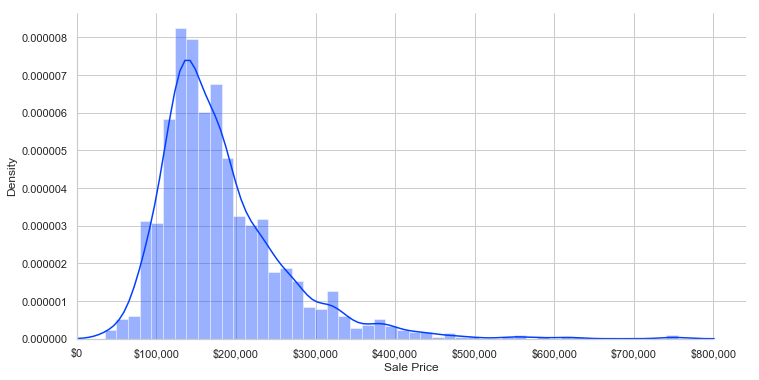

In [14]:
sns.set(style="whitegrid", palette='bright')

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    fig, ax = plt.subplots(figsize=(12,6))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '${:,.0F}'.format(x))) 
    p = sns.distplot(df_train['SalePrice'], kde=True, rug=False, ax=ax)
    ax.set(xlabel='Sale Price', ylabel='Density')
    sns.despine(trim=True)
    p.set(xlim=(0, None), ylim=(0,None))

Positively skewed with a few significant outliers at around $500-800k.

In [15]:
#skewness and kurtosis
print("Skew: {:.2f}".format(df_train['SalePrice'].skew()))
print("Kurtosis: {:.2f}".format(df_train['SalePrice'].kurt()))

Skew: 1.88
Kurtosis: 6.54


##  3.2.2 Bivariate analysis

**Relationship with selected numerical variables**

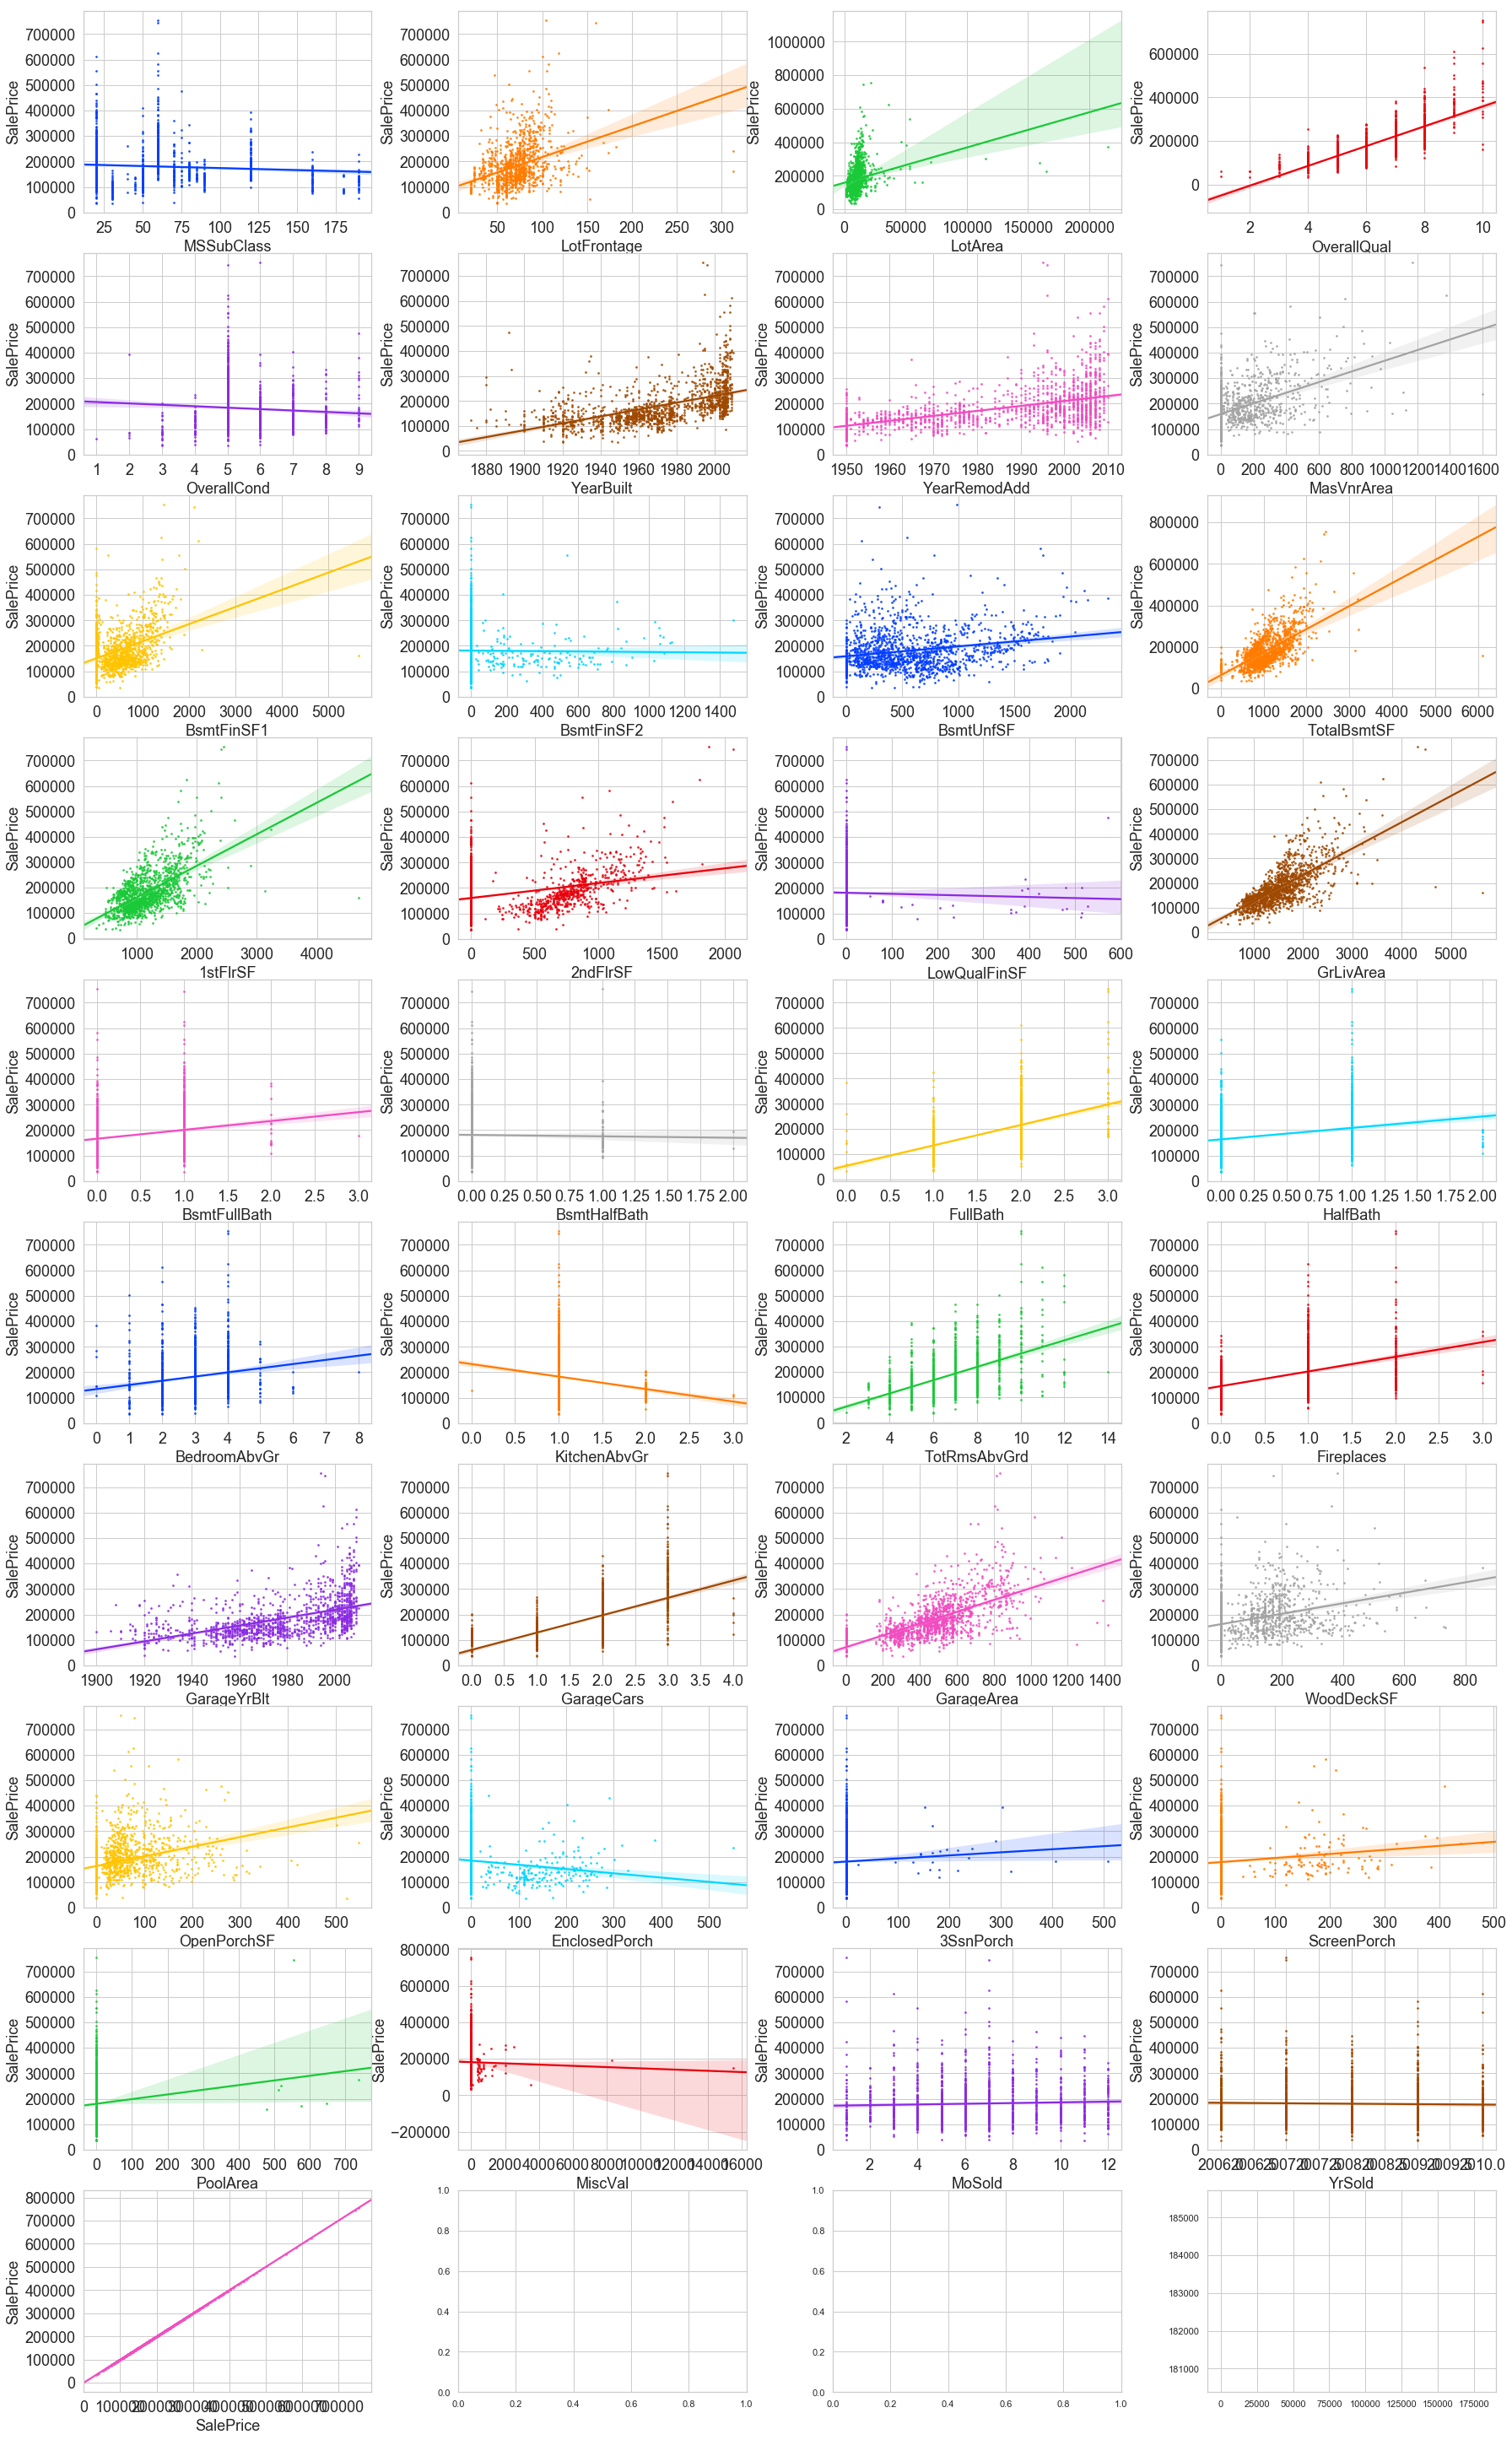

In [20]:
numeric_features = df_train.select_dtypes(exclude=['object']).columns.tolist()

grid_cols = 4
pair_plots = 1
grid_rows = math.ceil(len(numeric_features) / ((grid_cols // pair_plots)))
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(30,40))

axes = axes.ravel()
colix = 0
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.2, wspace=0.3)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    for i in range(len(numeric_features)):
        ax = axes[i]
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontname('Arial')
            label.set_fontsize(18)
        ax.set_ylabel('SalePrice', fontsize=18)    
        ax.set_xlabel(numeric_features[colix], fontsize=18)
       
        g = sns.regplot(x=numeric_features[colix], y='SalePrice', ax=ax, data=df_train, scatter_kws={'s':3})
        colix += 1

Looking at the regression plots above there are a few positive linear reltionships of varying stregnths:
* TotalBsmtSF
* 1stFlrFSF
* GrLivArea
* Garage Area

**Relationship with selected categorical "Space" segment variables**

* Ignore features with a > 15% number of nulls ( PoolQC, MiscFeature, Alley, Fence, FirePlaceQu)

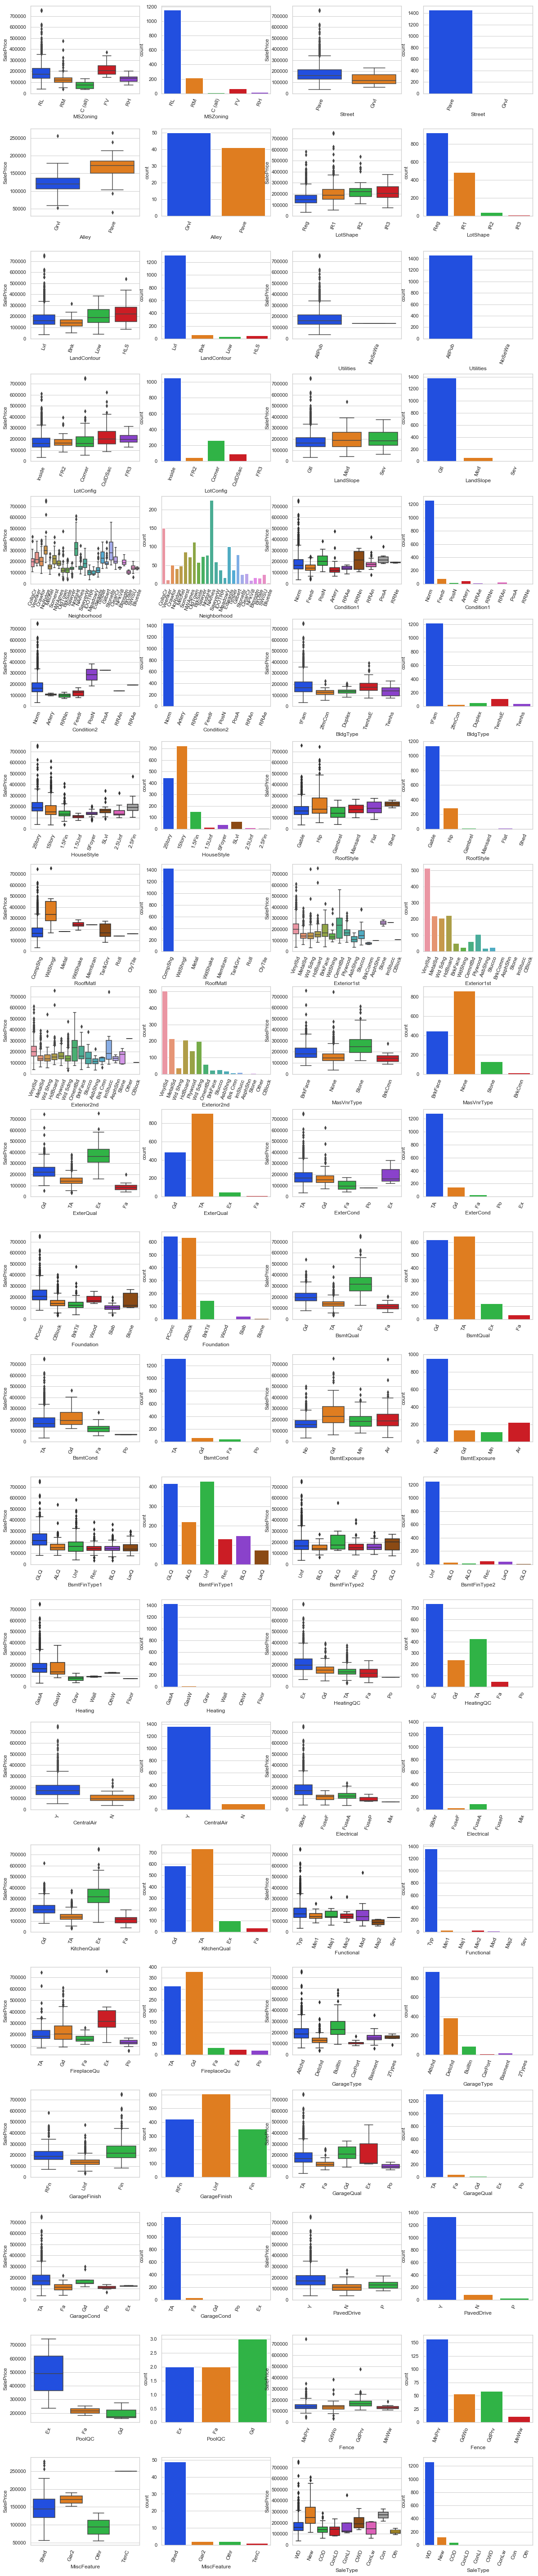

In [22]:
categorical_features = df_train.select_dtypes(include=['object']).columns.tolist()

feat_cols = ['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
           'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 
           'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
           'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']

grid_cols = 4
pair_plots = 2
grid_rows = len(categorical_features) // ((grid_cols // pair_plots))
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(20,80))
axes = axes.ravel()
dv = 'SalePrice'
colix = 0
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4, wspace=0.2)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    for i in range(0,grid_rows * grid_cols,2):
        g = sns.boxplot(x=categorical_features[colix], y=dv, data=df_train, ax=axes[i])
        p = sns.countplot(x=categorical_features[colix], data=df_train, ax=axes[i+1])
        g.set_xticklabels(g.get_xticklabels(), rotation=70, fontsize = 12)
        p.set_xticklabels(g.get_xticklabels(), rotation=70, fontsize = 12)
        if categorical_features[colix] in ['YearBuilt', 'YearRemodAdd']:
            g.set_xticklabels(g.get_xticklabels(), visible=False)
            p.set_xticklabels(p.get_xticklabels(), visible=False)
        colix += 1

**Observations:**

Most category distributions are heavily skewed to a single or a few values and should be considered for removal

* QverallQual - show a clear exponential distribution
* YearBuilt and YearRemodelled - show a recent increase in sales price bur the count plot indicates a surge in recent years of both units sold and remodelled
* MoSold - it's clear the most popular time for selling is in the summer (May through July) -  July sales seem to attain higher sales prices

**Decisions:**

Keep columns:
* OverallQual
* MoSold

Other columns can be included for now - but test the impact on accuracy if they are selectively removed.

## 3.3. Multivariate Analysis

### 3.3.1 Produce a Heatmap to examine the relative coefficicients between features


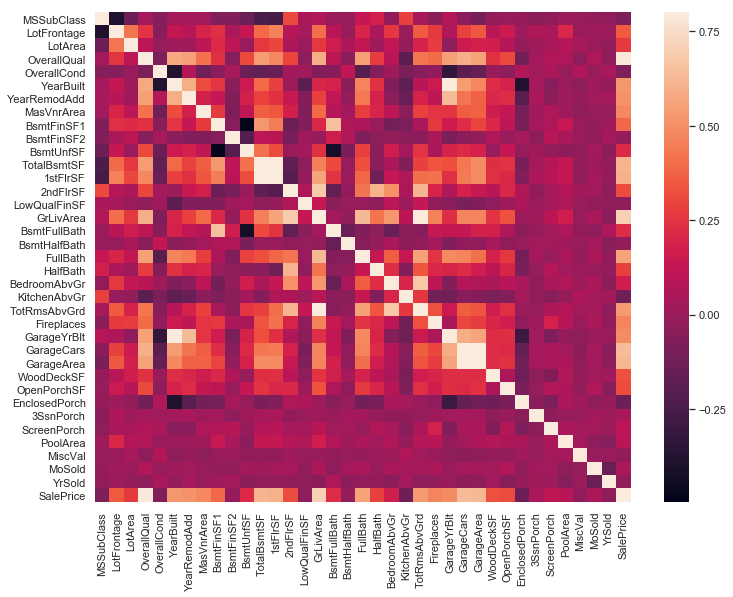

In [23]:
corrmat = df_train.corr()
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=0.8, square=False);

**Observations:**

OverallQual and GrLivArea are strongly correlated with SalePrice.  GarageCars (and GarageArea) too.

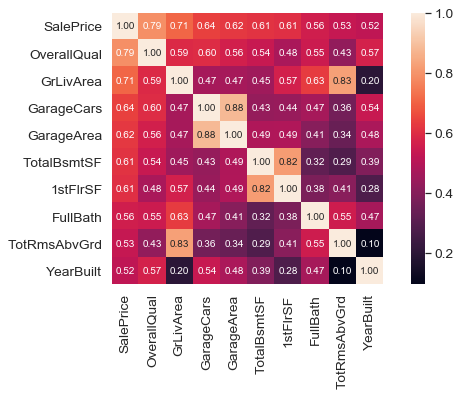

In [24]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
fig, ax = plt.subplots(figsize=(10, 5))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

**Observations:**
   * GarageCars and GarageArea are strongly correlated - not a huge surprise as the number of cars you can fit in a garage is dependent on the size of the garage
   * TotalBsmtSF is strongly correlated to 1stFlrSF - again undertandable unless you have either a massive basement or a exceptionally large 1st floor
  
**Decisons:**
   * We can drop GarageArea - as it's covered by GarageCars
   * We cab drop 1stFlrSF - as it's covered by TotalBsmtSF

### 3.3.2 Scatter plots between the target feature (SalePrice) and selected independent features

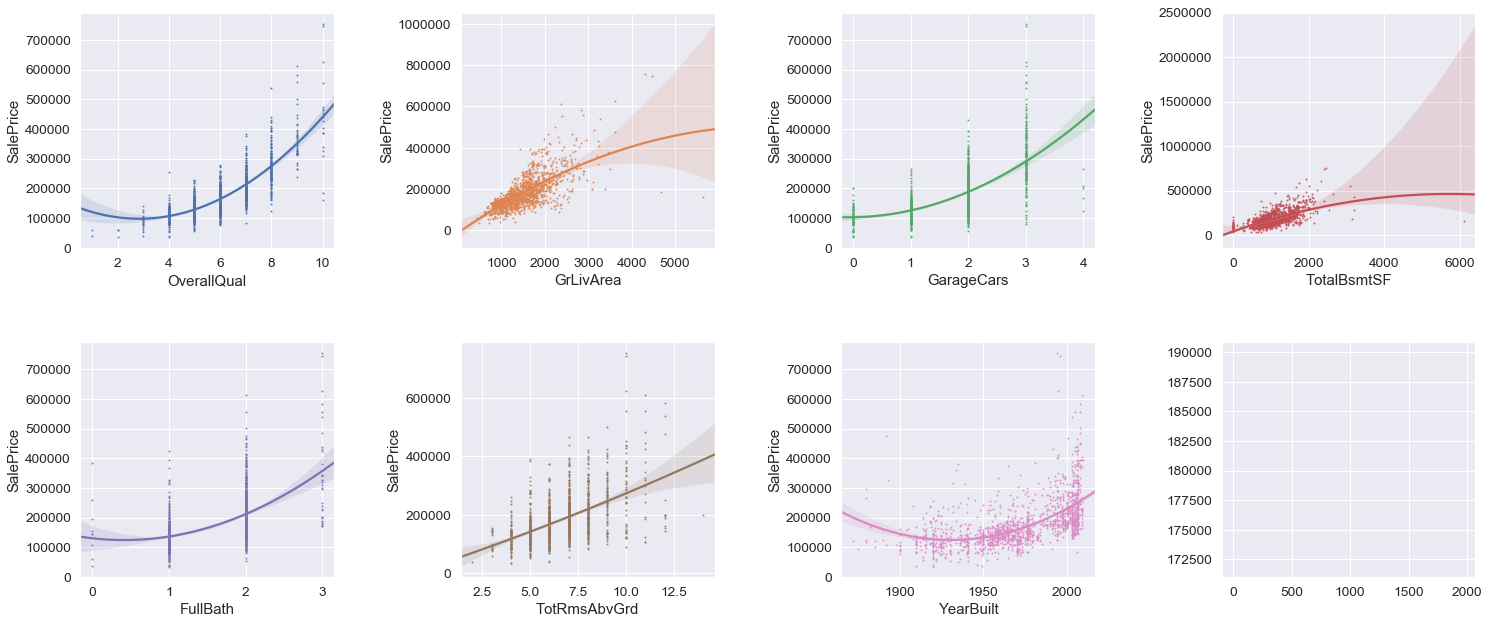

In [25]:
iv_cols = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'TotRmsAbvGrd','YearBuilt']
dv = df_train['SalePrice']
grid_cols = 4
pair_plots = 1
colix = 0
grid_rows = math.ceil(len(iv_cols) / ((grid_cols // pair_plots)))
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(25,8))
axes = axes.ravel()
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4, wspace=0.5)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    for i in range(len(iv_cols)):
        g = sns.regplot(x=iv_cols[colix], y=dv, ax=axes[i], data=df_train, scatter_kws={'s':1}, order=2)
        colix += 1

**Observations:**
   * TotalRmsAbvGrd and GrLivArea - appears to be a straight line indicating, unsurprisingly, there is a strong relationship between the number of rooms and the space available
   * YearBuilt and OverallQual - also show some degree of exponentiality especially at the top, most recent years.  It could indicate the maxing out of prices in the area - folks just won't pay more than a certain threshold for those neighborhoods
   * TotalBsmtSF is strongly correlated to 1stFlrSF - again, asindicated in the heatmap above, undertandable unless you have either a massive basement or a exceptionally large 1st floor

Some features have a very similar corrleation and overlap:
* TotalBsmtSF and 1stFlrSF have exactly the same correlation and are very likely to be aligend because the basement size will likely dictate the size of the 1st floor
* The key Garage variable is GarageCars, so we'll get rid of the others
* We'll treat all the Basement features in a similar way to the Garage features for the same reason (keeping TotalBsmtSF)

**Decisions:**
* Drop all Garage festures except GarageCars
* Drop all Basement features except TotalBsmtSF
* Drop 1stFlrSF as it's covered by TotalBsmtSF


# 4. Data Processing

## 4.2. Outliers - Univariate analysis

The primary concern here is to establish a threshold that defines an observation as an outlier. To do so, we'll standardize the data. In this context, data standardization means converting data values to have mean of 0 and a standard deviation of 1.

In [27]:
#standardizing data
saleprice_scaled = StandardScaler().fit_transform(df_train['SalePrice'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83870376]
 [-1.83352844]
 [-1.80092766]
 [-1.78329881]
 [-1.77448439]
 [-1.62337999]
 [-1.61708398]
 [-1.58560389]
 [-1.58560389]
 [-1.5731    ]]

outer range (high) of the distribution:
[[3.82897043]
 [4.04098249]
 [4.49634819]
 [4.71041276]
 [4.73032076]
 [5.06214602]
 [5.42383959]
 [5.59185509]
 [7.10289909]
 [7.22881942]]


**Observations:**

Lower range close to zero
Upper range indicates a couple of large outliers (the 7+ values)

**Decisions:**

Leave alone for now

## 4.2 Outliers - Bivariate analysis

### 4.2.1 GrLivArea

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


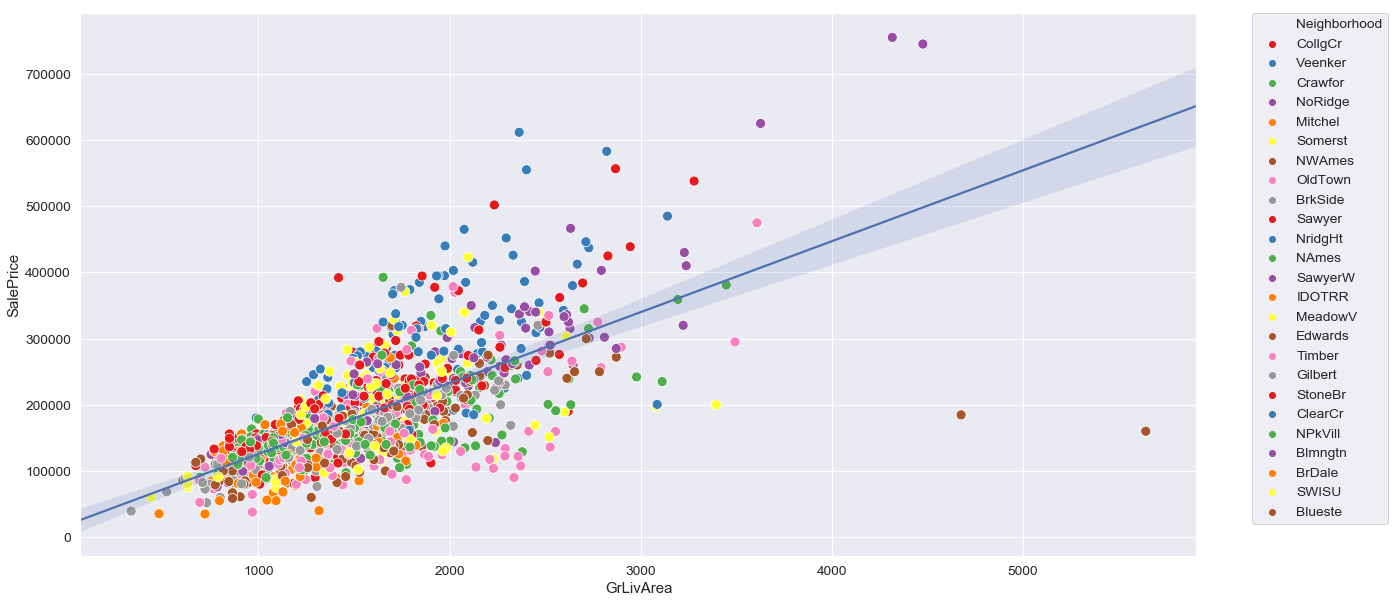

In [35]:
fig, ax = plt.subplots(figsize=(20,10))
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     fxn()
g = sns.scatterplot(df_train['GrLivArea'], df_train['SalePrice'], palette="Set1", hue=df_train['Neighborhood'], legend='full', s=100)
sns.regplot(df_train['GrLivArea'], df_train['SalePrice'], data=df_train, scatter=False)  # Add a regression line to the scatterplot
# Put the legend out of the figure
_ = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

**Investigate the outliers**

**Obervations:**
* We see the two outliers at the top, with SalePrices of over 700,000
* We also see two outliers with a large GrLivArea, over 4000 sq ft.  Odd given their respective SalePrice which you'd expect to be higher
* They all have above average number of rooms (TotRmsAbvGrd)

**Decisions:**
* The higher priced houses seem to followign the trend, so we'll leave them alone
* The lower priced houses with higher GrLivArea's seem like anomalies. Both are neighborhoods locates in Ames, near the university (https://www.zillow.com/ames-ia/) - so from the data and this brief analysis of the location I can't see why their prices would be so low.  So, let's investigate the outliers to double check on their details and if no surprises delete them.


In [36]:
print(df_train['TotRmsAbvGrd'].mean())
outliers_df = df_train.query('GrLivArea > 4000 | SalePrice > 700000').sort_values('SalePrice')
outliers_df.sort_values('SalePrice', ascending=False)

6.517808219178082


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
691,60,RL,104.000,21535,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.000,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455,Unf,0,989,2444,GasA,Ex,Y,SBrkr,2444,1872,0,4316,0,1,3,1,4,1,Ex,10,Typ,2,Ex,Attchd,1994.000,Fin,3,832,TA,TA,Y,382,50,0,0,0,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000
1182,60,RL,160.000,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.000,Gd,TA,PConc,Ex,TA,Av,GLQ,2096,Unf,0,300,2396,GasA,Ex,Y,SBrkr,2411,2065,0,4476,1,0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996.000,Fin,3,813,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000
523,60,RL,130.000,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.000,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260,Unf,0,878,3138,GasA,Ex,Y,SBrkr,3138,1538,0,4676,1,0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007.000,Fin,3,884,TA,TA,Y,208,406,0,0,0,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
1298,60,RL,313.000,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.000,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.000,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


In [37]:
# Deleting Outliers
print('\nBefore shape for {}: {}'.format('df_train', df_train.shape))
df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)
print('\nAfter shape for {}: {}'.format('df_train', df_train.shape))


Before shape for df_train: (1460, 80)


KeyError: 'Id'

#### 4.2.2.2 TotalBsmtSF

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    g = sns.scatterplot(df_train_new['TotalBsmtSF'], df_train_new['SalePrice'], palette="Set1", hue=df_train_new['Neighborhood'], legend='full', s=100)
    sns.regplot(df_train_new['TotalBsmtSF'], df_train_new['SalePrice'], data=df_train_new, scatter=False)  # Add a regression line to the scatterplot
# Put the legend out of the figure
_ = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

**Investigate the outliers**

**Observations:**
* Fairly even number of observations either sie of the regression line
* Some strange occurences with TotalBsmtSF > 3000 - but they look broadly on trend

**Decisions:**
* Do nothing

# 4. Wrangle Data
We have collected several assumptions and decisions regarding our datasets and solution requirements. So far we did not have to change a single feature or value to arrive at these. Let us now execute our decisions and assumptions for correcting, creating, and completing goals.

Correcting by dropping features This is a good starting goal to execute. By dropping features we are dealing with fewer data points. Speeds up our notebook and eases the analysis.

Based on our assumptions and decisions we want to drop

## 4.1 Missing data

* How prevalent is missing data?
* Is there a pattern?

We need to consider remedial actions to deal with missing values which may include:
   * Dropping columns or rows


* Setting null values to a default value (e.g. mode, mean, 0 or None)

In [ ]:
# Analyse the features for Null values - df_train
feat_analysis_nulls_df_train, feat_droplist_df_train = feature_null_analysis('df_train', df_train, NULL_PERC_DROP_PERC)
# Print the analysis - df_train
print_feature_null_analysis('df_train', feat_analysis_nulls_df_train)

# Analyse the features for Null values - df_test
feat_analysis_nulls_df_test, feat_droplist_df_test = feature_null_analysis('df_test', df_test, NULL_PERC_DROP_PERC)
# Print the analysis - df_test
print_feature_null_analysis('df_test', feat_analysis_nulls_df_test)
print(feat_droplist_df_train)

### 4.1.1 Dropping features - due to missing values

**Observations:**

If more than 15% of data is missing then the column is almost useless.  The following have 15% or more missing data:
* PoolQC
* MiscFeature
* Alley
* Fence
* FirePlaceQu
* LotFrontage

**Decisions:**

Based on the above we'll drop the following features:
   * Reason: 15% or more missing data:
       * PoolQC
       * MiscFeature
       * Alley
       * Fence
       * FireplaceQu
       * LotFrontage

In [ ]:
# Drop the recommended columns based on the analysis
cols = ['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','LotFrontage']
print('\nBefore shape for {}: {}'.format('df_train', df_train.shape))
print('\nBefore shape for {}: {}'.format('df_test', df_test.shape))
df_train.drop(cols, axis=1, inplace=True)
df_test.drop(cols, axis=1, inplace=True)
print('\nAfter shape for {}: {}'.format('df_train', df_train.shape))
print('\nAfter shape for {}: {}'.format('df_test', df_test.shape))

### 4.1.2 Dropping features - due to overlapping feature meaning
Some features have a very similar corrleation and meaning overlap.

**Observations:**

TotalBsmtSF and 1stFlrSF have exactly the same correlation and are very likely to be aligend because the basement size will likely dictate the size of the 1st floor
All the Garage variables have the same number of missing values (probably the same set of rows)
Decisions:

Reason: Feature overlap:
GarageType
GarageYrBlt
GarageFinish
GarageArea
GarageQual
GarageCond
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinSF1
BsmtFinType2
BsmtFinSF2
BsmtUnfSF

In [ ]:
cols = ['GarageType','GarageYrBlt','GarageFinish','GarageArea','GarageQual','GarageCond','BsmtQual','BsmtCond','BsmtExposure',
                     'BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2','BsmtUnfSF']
print('\nBefore shape for {}: {}'.format('df_train', df_train.shape))
print('\nBefore shape for {}: {}'.format('df_test', df_test.shape))
df_train.drop(cols, axis=1, inplace=True)
df_test.drop(cols, axis=1, inplace=True)
print('\nAfter shape for {}: {}'.format('df_train', df_train.shape))
print('\nAfter shape for {}: {}'.format('df_test', df_test.shape))

### 4.1.3 Populating nulls

From the list of features with missing values, less those we intend to drop, we have:

* Set object dtypes to their mode
* set numeriv dtypes to their median

In [ ]:
# df_combined['MasVnrType'].fillna('None', inplace=True)
for col in feat_analysis_nulls_df_combined:
    if col[1] == 'object':
        _, mode = col[2].split(': ')
        df_combined[col[0]].fillna(mode, inplace=True)
    elif 'float' in str(col[1]):
        _, median = col[2].split(': ')
        df_combined[col[0]].fillna(float(median), inplace=True)
    elif 'int' in str(col[1]):
        df_combined[col[0]].fillna(int(median), inplace=True)

# Analyse the features for Null values
feat_analysis_nulls_df_combined, feat_droplist_df_combined = feature_null_analysis('df_combined', df_combined, NULL_PERC_DROP_PERC)
# Print the analysis
print_feature_null_analysis('df_combined', feat_analysis_nulls_df_combined)

# 5. Features Engineering

Combine Train and Test data into one dataframe.

In [ ]:
# Combine Train and Test data
print('\nBefore concat - shape for {}: {} - '.format('df_train', df_train.shape))
print('\nBefore concat - shape for {}: {}'.format('df_test', df_test.shape))
ntrain = df_train.shape[0]
ntest = df_test.shape[0]
df_combined = pd.concat([df_train, df_test], sort=False)
print('\nAfter concat - shape for {}: {}'.format('df_combined', df_combined.shape))

In [ ]:
# Drop the rubbish
cols = ['MasVnrType','MasVnrArea','MSZoning','Utilities','BsmtFullBath','BsmtHalfBath','Functional','Exterior1st','Exterior2nd','Electrical',
        'KitchenQual','SaleType']

print('\nBefore shape for {}: {}'.format('df_train', df_train.shape))
print('\nBefore shape for {}: {}'.format('df_test', df_test.shape))
df_train.drop(cols, axis=1, inplace=True)
df_test.drop(cols, axis=1, inplace=True)
print('\nAfter shape for {}: {}'.format('df_train', df_train.shape))
print('\nAfter shape for {}: {}'.format('df_test', df_test.shape))

In [ ]:
# One-hot encode selected categorical features
# cat_features_transform = []
# df_with_dummies = pd.get_dummies(df_combined, columns = cols_to_transform)
chosen_cols = ['GrLivArea','TotalBsmtSF','OverallQual','YearBuilt']
df_temp = df_train_new[chosen_cols]
df_dummies = pd.get_dummies(df_temp)
print(len(list(df_dummies)))
df_dummies.head()

In [ ]:
# Feature Extraction with RFE
X = df_dummies
Y = df_train_new['SalePrice']
# feature extraction
model = LogisticRegression()
rfe = RFE(model, 3)
fit = rfe.fit(X, Y)
print("Num Features: {}".format(fit.n_features_))
print("Selected Features: {}".format(fit.support_))
print("Feature Ranking: {}".format(fit.ranking_))
# print("Num Features: %d") % fit.n_features_
# print("Selected Features: %s") % fit.support_
# print("Feature Ranking: %s") % fit.ranking_

## 5. Testing Assumptions

* Linearality
Diagnotics - 3.3.2 Scatter plots between the DV (SalePrice) and correlated IV's

In [ ]:
# Split Train and Test back out
print('\nBefore shape for {}: {}'.format('df_train', df_train.shape))
print('\nBefore shape for {}: {}'.format('df_test', df_test.shape))
df_train_new, df_test_new = df_combined[0:df_train.shape[0]:], df_combined[df_train.shape[0]::]
print('\nAfter shape for {}: {}'.format('df_train_new', df_train_new.shape))
print('\nAfter shape for {}: {}'.format('df_test_new', df_test_new.shape))
df_train_new.head()
# df_with_dummies.info()

### **Creating new feature extracting from existing**

**Observations**

Year Sold and Month Sold could possible be combine - but there is little evidence to suggest sales are significantly impacted by month of year.

YearRemodAdd is equal to YearBuilt if no remodelling has taken place but different if it has.  It's resonable t oassume that a redmodelled property would fetch a higher asking price so creating a new field to indicate if the property has been remodelled may be worthwhile. 

**Decision**

We decide to create a new feature called Remodelled.

In [ ]:
print("Before", df_train.shape, df_test.shape, combine[0].shape, combine[1].shape)

for df in combine:
    df['Remodelled'] = df.apply(lambda row: 1 if row['YearBuilt'] != row['YearRemodAdd'] else 0, axis=1)
    print()
    width = 20
    print('{: <{width}}{: <{width}}{: <{width}}'.format('YearBuilt', 'YearRemodAdd', 'Remodelled', width=PRINT_WIDTH))
    for x in (range(5)):
        print('{: <{width}}{: <{width}}{: <{width}}'.format(df_train['YearBuilt'][x], df_train['YearRemodAdd'][x], df_train['Remodelled'][x], 
                                                            width=width))

combine = [df_train, df_test]
print("After", df_train.shape, df_test.shape, combine[0].shape, combine[1].shape)
df_train.head()

### **Convert categorical feature to ordinal**

In [ ]:
# Set Category features to correct dtype and fill NaaN's with the median value
cols = ['YearBuilt', 'YearRemodAdd', 'MSSubClass', 'Street','LotShape','LandContour','LotConfig','LandSlope','Neighborhood','Condition1','Condition2',
        'BldgType','HouseStyle','RoofStyle', 'RoofMatl','Exterior1st','Exterior2nd','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond',
        'BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','FireplaceQu',
        'GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','SaleType','SaleCondition', 'GarageYrBlt', 'MasVnrType', 'MSZoning',
        'Utilities']

def parse_categorical(df):
    for col in cols:
        df[col] = df[col].astype('category')
        df[col] = df[col].cat.codes
        apositive = list(filter(lambda x:x>0, df[col]))  # We use the median value to populate any NaaN's - ignpre any -ve (NaaN's)
        if sum(apositive) == 0:  # But if there is only one category then the sum will be 0 (1 cat starting at 0)-so the median calc issues a warning
            df.loc[df[col] == -1, col] = 0  # Any NaaN's will be set to -1 - so we set them to 0, the only category that exists for this feature
        else:
            df.loc[df[col] == -1, col] = np.median(apositive)
        
for df in combine:
    parse_categorical(df)

combine = [df_train, df_test]
df_train.head()

### **Completing a numerical continuous feature**

Now we should start estimating and completing features with missing or null values.

We can consider three methods to complete a numerical continuous feature.

1. A simple way is to generate random numbers between mean and standard deviation.


2. More accurate way of guessing missing values is to use other correlated features. In our case we note correlation among Age, Gender, and Pclass. Guess Age values using median values for Age across sets of Pclass and Gender feature combinations. So, median Age for Pclass=1 and Gender=0, Pclass=1 and Gender=1, and so on...


3. Combine methods 1 and 2. So instead of guessing age values based on median, use random numbers between mean and standard deviation, based on sets of Pclass and Gender combinations.


Method 1 and 3 will introduce random noise into our models. The results from multiple executions might vary. We will use method 2.

In [ ]:
def parse_numeric(df, cols):
    for col in cols:
        df[col] = df[col].fillna(df[col].median())

cols = ['SalePrice', 'LotFrontage','MasVnrArea','BsmtHalfBath','BsmtFullBath','GarageArea','GarageCars','TotalBsmtSF','BsmtUnfSF','BsmtFinSF2','BsmtFinSF1']
parse_numeric(df_train, cols)
cols = ['LotFrontage','MasVnrArea','BsmtHalfBath','BsmtFullBath','GarageArea','GarageCars','TotalBsmtSF','BsmtUnfSF','BsmtFinSF2','BsmtFinSF1']
parse_numeric(df_test, cols)

check_cols(df_train,'Train')
check_cols(df_test,'Test')
df_train.info()
combine = [df_train, df_test]
df_train.head()
df_train['SalePrice'].value_counts()

### **Normalizing numerical continuous features**

Now we should consider normalizing continuous numerical feature.

In [ ]:
def normalize(df, cols):
    for col in cols:
        series_mean = df[col].mean()
        series_std = df[col].std()
        df[col] = (df[col] - series_mean) / series_std

cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 'LowQualFinSF', 
        'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch']
normalize(df_train, cols)

cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 'LowQualFinSF', 
        'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch']
normalize(df_test, cols)
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])

df_train.info()

combine = [df_train, df_test]
df_train.head()

# **Model, predict and solve**

Now we are ready to train a model and predict the required solution. There are 60+ predictive modelling algorithms to choose from. We must understand the type of problem and solution requirement to narrow down to a select few models which we can evaluate. Our problem is a regression problem. We want to identify relationship between output (SalePrice or not) with other variables or features (MSSubClass, LotArea etc...). We are also perfoming a category of machine learning which is called supervised learning as we are training our model with a given dataset. With these two criteria - Supervised Learning plus Regression, we can narrow down our choice of models to a few. These include:

* Logistic Regression
* KNN or k-Nearest Neighbors
* Support Vector Machines
* Naive Bayes classifier
* Decision Tree
* Random Forrest
* Perceptron
* Artificial neural network
* RVM or Relevance Vector Machine

In [ ]:

X_train = df_train.drop('SalePrice', axis=1)

Y_train = df_train['SalePrice']
X_test  = df_test.drop('Id', axis=1).copy()
# X_test = df_test
X_train.shape, Y_train.shape, X_test.shape
df_train['SalePrice']
# df_train = df_train.reset_index()
# df_test = df_test.reset_index()

### **Logistic Regression**

In [ ]:

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

We can use Logistic Regression to validate our assumptions and decisions for feature creating and completing goals. This can be done by calculating the coefficient of the features in the decision function.

Positive coefficients increase the log-odds of the response (and thus increase the probability), and negative coefficients decrease the log-odds of the response (and thus decrease the probability).

In [ ]:
coeff_df = pd.DataFrame(df_train.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])
coeff_df.sort_values(by='Correlation', ascending=False, inplace=True)

width=20
print('{: <{width}} {: >{width}}\n{: <{width}} {: >{width}}'.format('Feature', 'Correlation', '=======','===========', width=width))
for i in range(coeff_df.shape[0]):
    print('{: <{width}} {: >{width}.5F}'.format(coeff_df['Feature'].iloc[i], coeff_df['Correlation'].iloc[i], width=width))

### **Support Vector Machines**

Next we model using Support Vector Machines which are supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis. Given a set of training samples, each marked as belonging to one or the other of two categories, an SVM training algorithm builds a model that assigns new test samples to one category or the other, making it a non-probabilistic binary linear classifier. Reference Wikipedia.

Note that the model generates a confidence score which is lower than Logistics Regression model.

In [ ]:
# Support Vector Machines

svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

### **KNN or k-Nearest Neighbors**

In pattern recognition, the k-Nearest Neighbors algorithm (or k-NN for short) is a non-parametric method used for classification and regression. A sample is classified by a majority vote of its neighbors, with the sample being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). If k = 1, then the object is simply assigned to the class of that single nearest neighbor. Reference Wikipedia.

KNN confidence score is lower than both Logistics Regression and the SVM.

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

### **Naive Bayes classifiers**

In machine learning, naive Bayes classifiers are a family of simple probabilistic classifiers based on applying Bayes' theorem with strong (naive) independence assumptions between the features. Naive Bayes classifiers are highly scalable, requiring a number of parameters linear in the number of variables (features) in a learning problem. Reference Wikipedia.

The model generated confidence score is higher than KNN but lower than SVM and Logistical Regression.

In [ ]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

### **Perception**

The perceptron is an algorithm for supervised learning of binary classifiers (functions that can decide whether an input, represented by a vector of numbers, belongs to some specific class or not). It is a type of linear classifier, i.e. a classification algorithm that makes its predictions based on a linear predictor function combining a set of weights with the feature vector. The algorithm allows for online learning, in that it processes elements in the training set one at a time. Reference Wikipedia.

In [ ]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

### **Linear SVC**

In [ ]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

### **Stochastic Gradient Descent**

In [ ]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

### **Decision Tree**

This model uses a decision tree as a predictive model which maps features (tree branches) to conclusions about the target value (tree leaves). Tree models where the target variable can take a finite set of values are called classification trees; in these tree structures, leaves represent class labels and branches represent conjunctions of features that lead to those class labels. Decision trees where the target variable can take continuous values (typically real numbers) are called regression trees. Reference Wikipedia.

The model confidence score is ...

In [ ]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

### **Random Forests**

The next model Random Forests is one of the most popular. Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees (n_estimators=100) at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. Reference Wikipedia.

The model confidence score is the highest among models evaluated so far. We decide to use this model's output (Y_pred) for creating our competition submission of results.

In [ ]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

### **Model evaluation**

We can now rank our evaluation of all the models to choose the best one for our problem. While both Decision Tree and Random Forest score the same, we choose to use Random Forest as they correct for decision trees' habit of overfitting to their training set.

In [ ]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

### **Create submission file**

In [ ]:
submission = pd.DataFrame({
        'Id': df_test['Id'],
        'SalePrice': Y_pred
    })

submission.to_csv('C:/Users/770000411/OneDrive - Genpact/02 - Personal/Jupyter Projects/Predict House Prices/submission.csv', index=False)